In [49]:
import wandb
import pandas as pd
import wandb
import pandas as pd

api = wandb.Api()

In [2]:
sweep_ids = ["d1048p6n"]

runs = []
all_data = []
for sweep_id in sweep_ids:
    sweep = api.sweep(f"jchud-stanford-university/correlation-experiment/{sweep_id}")
    for run in sweep.runs:
        runs.append(run)
        row = {
            "sweep_id": sweep_id,
            "run_id": run.id,
            "model": run.config.get("model"),
            "temperature": run.config.get("temperature"),
            "seed": run.config.get("seed"),
            **run.summary._json_dict,
        }
        all_data.append(row)

df = pd.DataFrame(all_data)


In [3]:
for run in runs:
    # Get artifact containing the table
    for artifact in run.logged_artifacts():
        if "samples" in artifact.name:
            table = artifact.get("samples")
            table_df = pd.DataFrame(data=table.data, columns=table.columns)
            print(f"Run {run.id}: {len(table_df)} samples")
            print(table_df.head())

wandb:   1 of 1 files downloaded.  


Run 6fj9avjf: 10000 samples
   id                          sequence extracted_choice response
0   0  ,G%\h@}}SBaY)NjWjB?E033cHERsXJ\E                X        X
1   1  >-!y94^x4zXz'T]|X{U4e,krI^2|IrWi                X        X
2   2  2_DEaH(eZlag*cG~sBekbWq#W"ElhI{e                X        X
3   3  bt`;NiO9px`t6/c2#y\9H3pE1Q)6p#N~                X        X
4   4  "wBw76<aki%kZ\!C=Co_foV$xzS5wTTK                X        X


wandb:   1 of 1 files downloaded.  


Run ukxqld6a: 10000 samples
   id                          sequence extracted_choice response
0   0  ,G%\h@}}SBaY)NjWjB?E033cHERsXJ\E                D        D
1   1  >-!y94^x4zXz'T]|X{U4e,krI^2|IrWi                D        D
2   2  2_DEaH(eZlag*cG~sBekbWq#W"ElhI{e                D        D
3   3  bt`;NiO9px`t6/c2#y\9H3pE1Q)6p#N~                D        D
4   4  "wBw76<aki%kZ\!C=Co_foV$xzS5wTTK                D        D


wandb:   1 of 1 files downloaded.  


Run 067stdc3: 10000 samples
   id                          sequence extracted_choice response
0   0  ,G%\h@}}SBaY)NjWjB?E033cHERsXJ\E                B        B
1   1  >-!y94^x4zXz'T]|X{U4e,krI^2|IrWi                B        B
2   2  2_DEaH(eZlag*cG~sBekbWq#W"ElhI{e                B        B
3   3  bt`;NiO9px`t6/c2#y\9H3pE1Q)6p#N~                B        B
4   4  "wBw76<aki%kZ\!C=Co_foV$xzS5wTTK                C        C


wandb:   1 of 1 files downloaded.  


Run gc46olyu: 10000 samples
   id                          sequence extracted_choice response
0   0  ,G%\h@}}SBaY)NjWjB?E033cHERsXJ\E                A        A
1   1  >-!y94^x4zXz'T]|X{U4e,krI^2|IrWi                A        A
2   2  2_DEaH(eZlag*cG~sBekbWq#W"ElhI{e                A        A
3   3  bt`;NiO9px`t6/c2#y\9H3pE1Q)6p#N~                A        A
4   4  "wBw76<aki%kZ\!C=Co_foV$xzS5wTTK                A        A


In [18]:
# Create pivot table for temperature = 1.0
df_temp0 = df[df['temperature'] == 0.0]

pivot_0 = df_temp0.pivot_table(
    index='id',
    columns='model',
    values='extracted_choice',
    aggfunc='first'
)

print(f"Pivot 1.0 shape: {pivot_0.shape}")

Pivot 1.0 shape: (10000, 7)


In [43]:
# # %% Simple Correlation Analysis (no bootstrapping)

# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Create pivot table
# pivot = df.pivot_table(
#     index='id',
#     columns='model',
#     values='extracted_choice',
#     aggfunc='first'
# )

# # Encode choices as numbers
# choice_map = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'X': np.nan}
# pivot_numeric = pivot.replace(choice_map)

# # Compute correlation matrix
# corr = pivot_numeric.corr()

# # Plot heatmap
# short_names = [name.split('/')[-1] for name in corr.columns]

# plt.figure(figsize=(10, 8))
# sns.heatmap(corr, annot=True, fmt='.3f', cmap='RdBu_r', center=0,
#             vmin=-0.3, vmax=0.3,
#             xticklabels=short_names, yticklabels=short_names)
# plt.title('Cross-Model Correlation). Temperature 0')
# plt.tight_layout()
# plt.show()

In [29]:
# %% [markdown]
# ## Debug: Investigate invalid extractions

# %%
# Check all unique values in extracted_choice
print("All unique values in extracted_choice:")
print(df['extracted_choice'].value_counts(dropna=False))

# %%
# Find anything that's not A, B, C, D, or X
valid_choices = ['A', 'B', 'C', 'D', 'X']
invalid_df = df[~df['extracted_choice'].isin(valid_choices)]

print(f"\nInvalid extractions (not A/B/C/D/X): {len(invalid_df)}")
if len(invalid_df) > 0:
    print(invalid_df[['model', 'id', 'extracted_choice', 'response']].head(20))

# %%
# Check for empty strings specifically
empty_df = df[df['extracted_choice'] == '']
print(f"\nEmpty string extractions: {len(empty_df)}")
if len(empty_df) > 0:
    print("\nExamples of empty extractions:")
    for idx, row in empty_df.head(10).iterrows():
        print(f"\nModel: {row['model']}")
        print(f"ID: {row['id']}")
        print(f"Choice: '{row['extracted_choice']}'")
        print(f"Response: {row['response'][:200]}...")

# %%
# Check for whitespace or other weird values
print("\nValue types and lengths:")
for val in df['extracted_choice'].unique():
    count = len(df[df['extracted_choice'] == val])
    print(f"  '{val}' (len={len(str(val))}): {count} occurrences")

# %%
# Breakdown by model - which models have the most issues?
print("\nInvalid extractions by model:")
for model in df['model'].unique():
    model_df = df[df['model'] == model]
    valid = model_df['extracted_choice'].isin(['A', 'B', 'C', 'D']).sum()
    total = len(model_df)
    print(f"  {model}: {valid}/{total} valid ({100*valid/total:.1f}%)")

All unique values in extracted_choice:
extracted_choice
A    28476
D    22092
C    10839
X     9951
B     8642
Name: count, dtype: int64

Invalid extractions (not A/B/C/D/X): 0

Empty string extractions: 0

Value types and lengths:
  'D' (len=1): 22092 occurrences
  'X' (len=1): 9951 occurrences
  'B' (len=1): 8642 occurrences
  'C' (len=1): 10839 occurrences
  'A' (len=1): 28476 occurrences

Invalid extractions by model:
  Qwen/Qwen2.5-3B-Instruct: 9933/10000 valid (99.3%)
  Qwen/Qwen2.5-7B-Instruct: 10000/10000 valid (100.0%)
  google/gemma-3-12b-it: 10000/10000 valid (100.0%)
  google/gemma-3-1b-it: 9993/10000 valid (99.9%)
  google/gemma-3-4b-it: 10000/10000 valid (100.0%)
  meta-llama/Llama-3.1-8B-Instruct: 10000/10000 valid (100.0%)
  meta-llama/Llama-3.2-1B-Instruct: 123/10000 valid (1.2%)
  meta-llama/Llama-3.2-3B-Instruct: 10000/10000 valid (100.0%)


In [44]:
# Check: after filtering by temperature, should have 1 row per (model, id)
df_temp0 = df[df['temperature'] == 0.0]

duplicates = df_temp0.groupby(['model', 'id']).size()
print(f"Max rows per (model, id): {duplicates.max()}")
print(f"Should be 1. If >1, you have duplicate runs at same temperature.")

# If duplicates exist, show them:
if duplicates.max() > 1:
    print("\nDuplicate runs found:")
    print(df_temp0[['model', 'temperature', 'seed']].drop_duplicates())

Max rows per (model, id): 1
Should be 1. If >1, you have duplicate runs at same temperature.


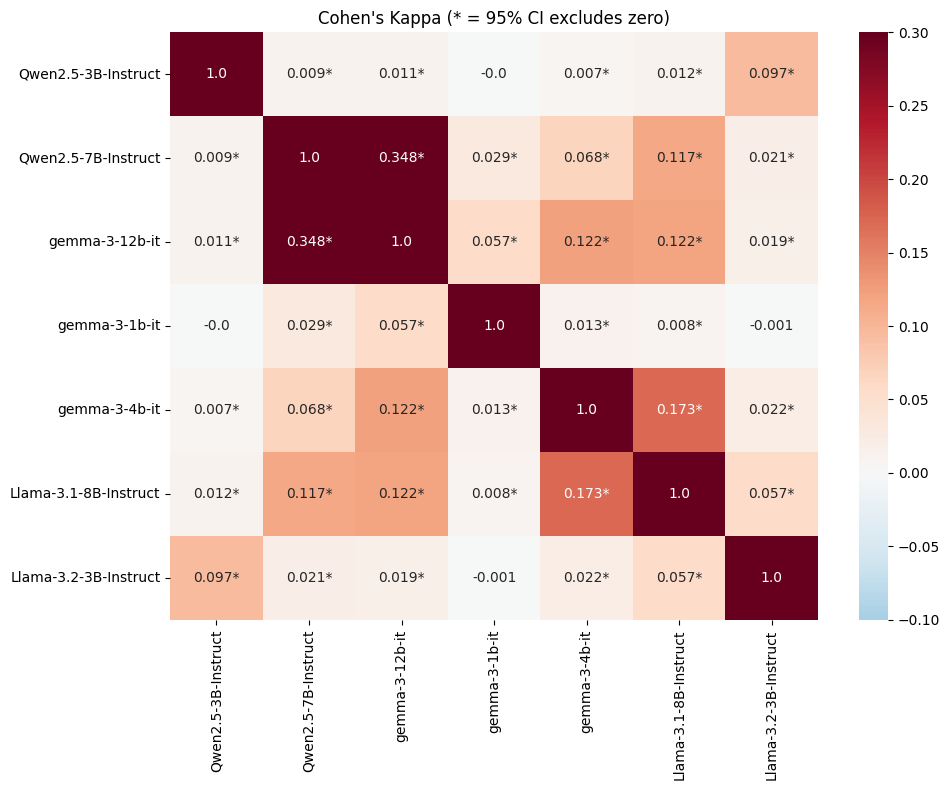

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def compute_cohen_kappa(choices1, choices2):
    """Cohen's kappa: agreement corrected for chance."""
    valid_mask = (choices1.isin(['A','B','C','D'])) & (choices2.isin(['A','B','C','D']))
    if valid_mask.sum() == 0:
        return np.nan
    
    c1, c2 = choices1[valid_mask], choices2[valid_mask]
    
    # Observed agreement
    observed = (c1 == c2).mean()
    
    # Expected agreement by chance
    p1 = c1.value_counts(normalize=True)
    p2 = c2.value_counts(normalize=True)
    expected = sum(p1.get(x, 0) * p2.get(x, 0) for x in ['A','B','C','D'])
    
    if expected == 1:
        return 1.0 if observed == 1 else 0.0
    
    return (observed - expected) / (1 - expected)


def bootstrap_kappa_ci(pivot_df, n_bootstrap=1000, ci=95, seed=42):
    """Bootstrap CIs for pairwise Cohen's kappa."""
    np.random.seed(seed)
    
    models = pivot_df.columns.tolist()
    n_models = len(models)
    n_samples = len(pivot_df)
    
    boot_vals = np.zeros((n_bootstrap, n_models, n_models))
    
    for b in range(n_bootstrap):
        idx = np.random.choice(n_samples, size=n_samples, replace=True)
        boot_sample = pivot_df.iloc[idx]
        
        for i, m1 in enumerate(models):
            for j, m2 in enumerate(models):
                if i == j:
                    boot_vals[b, i, j] = 1.0
                else:
                    boot_vals[b, i, j] = compute_cohen_kappa(boot_sample[m1], boot_sample[m2])
    
    # Percentiles
    alpha = (100 - ci) / 2
    ci_lower = np.percentile(boot_vals, alpha, axis=0)
    ci_upper = np.percentile(boot_vals, 100 - alpha, axis=0)
    
    # Point estimate
    point_est = np.zeros((n_models, n_models))
    for i, m1 in enumerate(models):
        for j, m2 in enumerate(models):
            if i == j:
                point_est[i, j] = 1.0
            else:
                point_est[i, j] = compute_cohen_kappa(pivot_df[m1], pivot_df[m2])
    
    point_df = pd.DataFrame(point_est, index=models, columns=models)
    ci_lower_df = pd.DataFrame(ci_lower, index=models, columns=models)
    ci_upper_df = pd.DataFrame(ci_upper, index=models, columns=models)
    
    return point_df, ci_lower_df, ci_upper_df


# === RUN ===
# pivot = df[df['temperature'] == 0.0].pivot_table(
#     index='id', columns='model', values='extracted_choice', aggfunc='first'
# )

pivot = df[df['temperature'] == 0.0].pivot_table(
    index='id', columns='model', values='extracted_choice', aggfunc='first'
)

# Remove Llama 1B
pivot = pivot.drop(columns=[col for col in pivot.columns if 'Llama-3.2-1B' in col])

kappa, ci_low, ci_high = bootstrap_kappa_ci(pivot, n_bootstrap=1000)

# Plot
short_names = [name.split('/')[-1] for name in kappa.columns]
sig_mask = (ci_low > 0) | (ci_high < 0)

annot_text = kappa.round(3).astype(str).copy()
for i in range(len(kappa)):
    for j in range(len(kappa)):
        if i != j and sig_mask.iloc[i, j]:
            annot_text.iloc[i, j] = f"{kappa.iloc[i, j]:.3f}*"

plt.figure(figsize=(10, 8))
sns.heatmap(kappa, annot=annot_text, fmt='', cmap='RdBu_r', center=0,
            vmin=-0.1, vmax=0.3,
            xticklabels=short_names, yticklabels=short_names)
plt.title("Cohen's Kappa (* = 95% CI excludes zero)")
plt.tight_layout()
plt.show()

Testing that it's all biased toward one value

 1. EXTRACTION VALIDITY CHECK
status                            INVALID
model                                    
meta-llama/Llama-3.2-1B-Instruct   0.9877
Qwen/Qwen2.5-3B-Instruct           0.0067
google/gemma-3-1b-it               0.0007
Qwen/Qwen2.5-7B-Instruct           0.0000
google/gemma-3-12b-it              0.0000
google/gemma-3-4b-it               0.0000
meta-llama/Llama-3.1-8B-Instruct   0.0000
meta-llama/Llama-3.2-3B-Instruct   0.0000

⚠️  High 'INVALID' rates (>50%) mean your regex is failing for that model.

 2. MARGINAL DISTRIBUTION (MODE COLLAPSE CHECK)


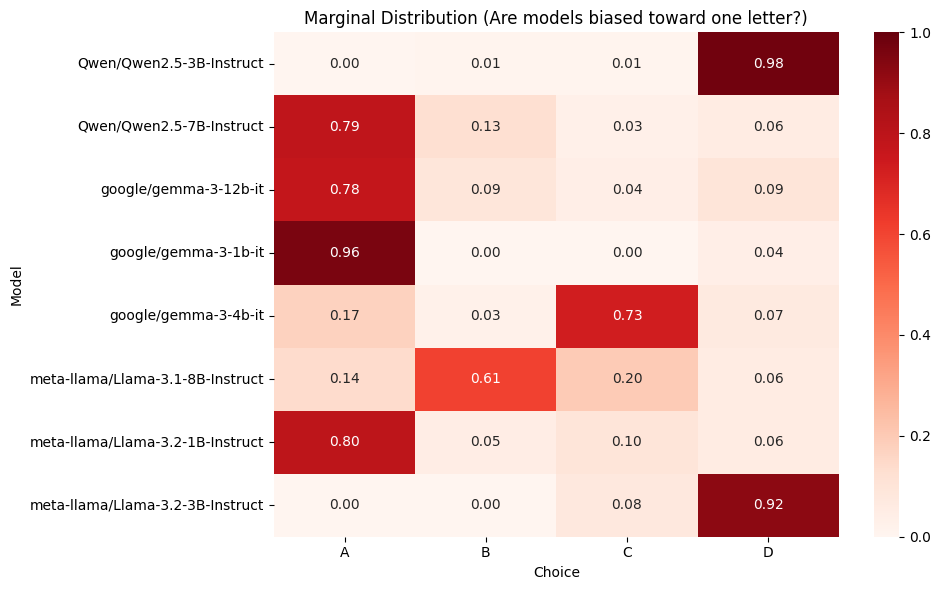

⚠️  Look for rows where one column is dark red (>0.8). This is Mode Collapse.

 3. PAIRWISE DISAGREEMENT INSPECTOR

=== Deep Dive: Qwen/Qwen2.5-3B-Instruct vs google/gemma-3-1b-it ===

Confusion Matrix (Raw Counts):
google/gemma-3-1b-it         A  B  C    D  X
Qwen/Qwen2.5-3B-Instruct                    
A                           23  0  0    1  0
B                           92  1  1    4  1
C                           93  0  0    6  0
D                         9312  5  1  387  6
X                           60  1  0    6  0

Sample Disagreements (9589 total):
model Qwen/Qwen2.5-3B-Instruct google/gemma-3-1b-it
id                                                 
0                            D                    A
1                            D                    A
2                            D                    A
3                            D                    A
4                            D                    A
5                            D                    A
6                

In [39]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def verify_data_integrity(df):
    print("="*40)
    print(" 1. EXTRACTION VALIDITY CHECK")
    print("="*40)
    # Check how many 'X' or NaNs each model has
    valid_choices = ['A', 'B', 'C', 'D']
    
    # Create a helper column for status
    df['status'] = df['extracted_choice'].apply(lambda x: x if x in valid_choices else 'INVALID')
    
    validity = df.groupby('model')['status'].value_counts(normalize=True).unstack().fillna(0)
    
    # Check if 'INVALID' column exists, if not, create it for display
    if 'INVALID' not in validity.columns:
        validity['INVALID'] = 0.0
        
    print(validity[['INVALID']].sort_values('INVALID', ascending=False))
    print("\n⚠️  High 'INVALID' rates (>50%) mean your regex is failing for that model.")

    print("\n" + "="*40)
    print(" 2. MARGINAL DISTRIBUTION (MODE COLLAPSE CHECK)")
    print("="*40)
    # See if models are just guessing "A" 90% of the time
    dist = df[df['extracted_choice'].isin(valid_choices)].groupby('model')['extracted_choice'].value_counts(normalize=True).unstack().fillna(0)
    
    # Plotting for easier visual debugging
    plt.figure(figsize=(10, 6))
    sns.heatmap(dist, annot=True, fmt='.2f', cmap='Reds', vmin=0, vmax=1)
    plt.title("Marginal Distribution (Are models biased toward one letter?)")
    plt.xlabel("Choice")
    plt.ylabel("Model")
    plt.tight_layout()
    plt.show()
    
    print("⚠️  Look for rows where one column is dark red (>0.8). This is Mode Collapse.")

    print("\n" + "="*40)
    print(" 3. PAIRWISE DISAGREEMENT INSPECTOR")
    print("="*40)
    
    # Create Pivot for comparison
    pivot = df.pivot_table(index='id', columns='model', values='extracted_choice', aggfunc='first')
    
    return pivot

# === RUN THE CHECKS ===
pivot = verify_data_integrity(df)

# === 4. DEEP DIVE INTO SPECIFIC PAIRS ===
# Replace these with the two models that had 0.04 agreement in your previous plot
model_a = 'Qwen/Qwen2.5-3B-Instruct' 
model_b = 'google/gemma-3-1b-it'      

if model_a in pivot.columns and model_b in pivot.columns:
    print(f"\n=== Deep Dive: {model_a} vs {model_b} ===")
    
    # 1. Confusion Matrix
    conf_matrix = pd.crosstab(pivot[model_a], pivot[model_b])
    print("\nConfusion Matrix (Raw Counts):")
    print(conf_matrix)
    
    # 2. Show Disagreements
    disagreements = pivot[pivot[model_a] != pivot[model_b]]
    print(f"\nSample Disagreements ({len(disagreements)} total):")
    print(disagreements[[model_a, model_b]].head(10))
else:
    print(f"\nCould not find {model_a} or {model_b} in columns.")